In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import Dataset
from torchvision.datasets import ImageFolder
from torchvision.transforms import v2
import torchvision.utils as utils
import copy

import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from skimage import io, transform
import pandas as pd

from tqdm.auto import tqdm

import ml_library as ML

In [2]:
history = {
    'model': str,
    'batch_size': int,
    'learning_rate': float,
    'momentum': None,
    'optimizer': str,
    'training_loss': [],
    'validation_loss': [],
    'training_accuracy': [],
    'validation_accuracy': []
}

# **Lab B3:** Medical Imaging Analysis

In this lab you will set up, and train a model that seeks to perform classification of medical OCT scans. In the data there are four classes of scans: Healthy, CNV, DME and DRUSEN. The last three are eye diseases that cause visible damage to the retina and can be spotted through the OCT scans.

Your job is to set up the tranforms, the model, fit function, test function and the parameters. You must also tune the parameters and add more transforms to reach best performance possible.

IMPORTANT: The data is divided in test, validation and train sets. Make sure to use all three sets properly.

In [3]:
classes = [0, 1, 2, 3]
class_labels = ['CNV', 'DME', 'DRUSEN', 'NORMAL']

In [4]:
path_to_data = 'data/'
path_train = path_to_data + 'train'
path_test = path_to_data + 'test'
path_val = path_to_data + 'val'

Source:

- https://debuggercafe.com/pytorch-imagefolder-for-training-cnn-models/

**First Step:** Load the Data, setup Transforms, and Initialize the Dataloader


[Here](https://pytorch.org/vision/stable/transforms.html) is a great resource to learn more about the different transforms that can be added. The goal of the transform is to properly prepare the data to be sent to the model and to add data augmentation. You may have pictures of different resolution sizes, so here is a good time to set a transform to make the sizes of images uniform.

In [5]:
size = (224, 224)

# Transforms for train set
train_transform = v2.Compose([
    # v2.RandomResizedCrop(size=size, antialias=True),
    v2.Resize(size=size),
    # v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    v2.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    # v2.RandomRotation(degrees=(30, 70)),
    v2.ToTensor(),
    # v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Transforms for test/val set
test_val_transform = v2.Compose([
    v2.Resize(size=size),
    v2.ToTensor(),
    # v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                 ])

/root/miniconda3/envs/uECE189A/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [6]:
dataset_train = ImageFolder(root=path_train, transform=train_transform)
dataset_test = ImageFolder(root=path_test, transform=test_val_transform)
dataset_val = ImageFolder(root=path_val, transform=test_val_transform)

In [7]:
# Batch Size
batch_size = 32

# Number of workers
num_workers = 4

In [8]:
#Initialize dataloader for train set
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size = batch_size, shuffle=True, 
                                             pin_memory = True,
                                             num_workers=num_workers,
                                             persistent_workers=True)

#Initialize dataloader for test set
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size = batch_size, shuffle=False)

#Initialize dataloader for val set
val_loader = torch.utils.data.DataLoader(dataset_val, batch_size = batch_size, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 torch.Size([32, 3, 224, 224]) torch.Size([32])
1 torch.Size([32, 3, 224, 224]) torch.Size([32])
2 torch.Size([32, 3, 224, 224]) torch.Size([32])
3 torch.Size([32, 3, 224, 224]) torch.Size([32])
3 3 1 0 1 0 3 1 1 0 3 0 3 0 3 2 0 0 1 1 1 1 0 3 3 1 3 3 3 1 3 2


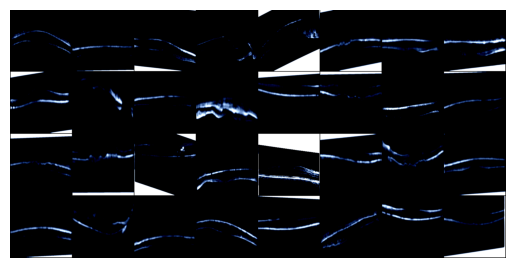

In [9]:
# Helper function to show a batch
def show_batch(sample_batched):
    images_batch, labels_batch = \
            sample_batched[0], sample_batched[1]

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    print(' '.join('%d' % labels_batch[j] for j in range(batch_size)))

for i_batch, sample_batched in enumerate(train_loader):
    print(i_batch, sample_batched[0].size(),
          sample_batched[1].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()

        
        break

In [10]:
images_batch, labels_batch = \
            sample_batched[0], sample_batched[1]

**Second Step:** Design Model's Architecture and code it here in with PyTorch.



In [11]:
torch.manual_seed(0)

# Instantiate Pretrained ResNet
# model = models.resnet50()
model = models.resnet18()

# Modify final layer
# model.fc = nn.Linear(in_features=2048, out_features=(len(classes)), bias=True)
model.fc = nn.Linear(in_features=512, out_features=(len(classes)), bias=True)

# Load onto GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

# View Model to validate
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

**Third Step:** Code Fit and Test functions. This is similar to Lab 3, but this time make sure to use the validation set as well.

Define in `ml_library.py`.

**Fourth Step:** Set Parameters and run model.


In [12]:
# Define Parameters
num_epochs = 200
lr = 0.0001
momentum = 0.9
hist = copy.deepcopy(history)

In [13]:
# Define Loss Fuction
loss_function = nn.CrossEntropyLoss()

# Define Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)

hist['model'] = 'ResNet18'
hist['batch_size'] = batch_size
hist['learning_rate'] = lr
hist['momentum'] = momentum
hist['optimizer'] = 'SGD'

In [14]:
hist = ML.train(model=model, loss_fn=loss_function, optimizer=optimizer, 
                train_loader=train_loader, test_loader=val_loader, num_epochs=num_epochs,
                device = device, history=hist)

  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [1/200] End, Training Loss: 1.2851., Validation Loss: 1.4323., Training Accuracy: 29.94 %, Validation Accuracy: 25.84 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [2/200] End, Training Loss: 1.3999., Validation Loss: 1.4085., Training Accuracy: 33.31 %, Validation Accuracy: 27.95 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [3/200] End, Training Loss: 1.3815., Validation Loss: 1.4246., Training Accuracy: 36.32 %, Validation Accuracy: 29.97 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [4/200] End, Training Loss: 1.3024., Validation Loss: 1.3829., Training Accuracy: 38.83 %, Validation Accuracy: 30.07 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [5/200] End, Training Loss: 1.2677., Validation Loss: 1.3958., Training Accuracy: 40.89 %, Validation Accuracy: 28.91 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [6/200] End, Training Loss: 1.3203., Validation Loss: 1.3815., Training Accuracy: 42.82 %, Validation Accuracy: 28.24 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [7/200] End, Training Loss: 1.3150., Validation Loss: 1.3758., Training Accuracy: 45.46 %, Validation Accuracy: 30.84 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [8/200] End, Training Loss: 1.2497., Validation Loss: 1.3460., Training Accuracy: 50.30 %, Validation Accuracy: 34.68 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [9/200] End, Training Loss: 1.1770., Validation Loss: 1.3177., Training Accuracy: 53.21 %, Validation Accuracy: 36.70 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [10/200] End, Training Loss: 1.2358., Validation Loss: 1.2846., Training Accuracy: 54.14 %, Validation Accuracy: 38.33 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [11/200] End, Training Loss: 0.9381., Validation Loss: 1.3049., Training Accuracy: 52.74 %, Validation Accuracy: 36.02 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [12/200] End, Training Loss: 0.9547., Validation Loss: 1.3829., Training Accuracy: 49.35 %, Validation Accuracy: 31.12 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [13/200] End, Training Loss: 1.0394., Validation Loss: 1.2125., Training Accuracy: 60.44 %, Validation Accuracy: 43.23 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [14/200] End, Training Loss: 0.9457., Validation Loss: 1.2335., Training Accuracy: 57.78 %, Validation Accuracy: 41.88 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [15/200] End, Training Loss: 1.0474., Validation Loss: 1.2368., Training Accuracy: 48.42 %, Validation Accuracy: 37.56 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [16/200] End, Training Loss: 0.9536., Validation Loss: 1.3475., Training Accuracy: 60.42 %, Validation Accuracy: 34.10 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [17/200] End, Training Loss: 0.7825., Validation Loss: 1.1965., Training Accuracy: 66.04 %, Validation Accuracy: 42.36 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [18/200] End, Training Loss: 1.0296., Validation Loss: 1.3952., Training Accuracy: 64.41 %, Validation Accuracy: 32.56 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [19/200] End, Training Loss: 0.6272., Validation Loss: 1.2394., Training Accuracy: 66.92 %, Validation Accuracy: 36.70 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [20/200] End, Training Loss: 0.6920., Validation Loss: 1.1180., Training Accuracy: 68.55 %, Validation Accuracy: 49.38 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [21/200] End, Training Loss: 1.2888., Validation Loss: 1.2848., Training Accuracy: 66.97 %, Validation Accuracy: 38.52 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [22/200] End, Training Loss: 0.4753., Validation Loss: 1.2573., Training Accuracy: 68.72 %, Validation Accuracy: 35.25 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [23/200] End, Training Loss: 0.6126., Validation Loss: 1.0815., Training Accuracy: 66.04 %, Validation Accuracy: 51.30 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [24/200] End, Training Loss: 0.5608., Validation Loss: 1.0767., Training Accuracy: 71.26 %, Validation Accuracy: 49.57 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [25/200] End, Training Loss: 0.4516., Validation Loss: 1.0740., Training Accuracy: 72.74 %, Validation Accuracy: 50.62 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [26/200] End, Training Loss: 0.5676., Validation Loss: 1.1566., Training Accuracy: 68.32 %, Validation Accuracy: 42.94 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [27/200] End, Training Loss: 0.6533., Validation Loss: 1.5116., Training Accuracy: 52.76 %, Validation Accuracy: 32.76 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [28/200] End, Training Loss: 0.5263., Validation Loss: 1.1286., Training Accuracy: 63.83 %, Validation Accuracy: 48.61 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [29/200] End, Training Loss: 0.7480., Validation Loss: 1.1862., Training Accuracy: 71.31 %, Validation Accuracy: 40.92 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [30/200] End, Training Loss: 0.5351., Validation Loss: 1.0135., Training Accuracy: 75.90 %, Validation Accuracy: 54.47 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [31/200] End, Training Loss: 0.9853., Validation Loss: 1.0625., Training Accuracy: 70.21 %, Validation Accuracy: 53.31 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [32/200] End, Training Loss: 1.1264., Validation Loss: 1.0391., Training Accuracy: 73.04 %, Validation Accuracy: 54.27 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [33/200] End, Training Loss: 0.6211., Validation Loss: 1.0299., Training Accuracy: 69.18 %, Validation Accuracy: 54.56 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [34/200] End, Training Loss: 0.6641., Validation Loss: 1.0639., Training Accuracy: 77.16 %, Validation Accuracy: 53.60 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [35/200] End, Training Loss: 0.6290., Validation Loss: 1.0117., Training Accuracy: 76.48 %, Validation Accuracy: 56.87 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [36/200] End, Training Loss: 0.7009., Validation Loss: 1.5708., Training Accuracy: 63.15 %, Validation Accuracy: 36.22 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [37/200] End, Training Loss: 0.7816., Validation Loss: 0.9962., Training Accuracy: 77.18 %, Validation Accuracy: 57.73 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [38/200] End, Training Loss: 0.8338., Validation Loss: 1.0058., Training Accuracy: 80.07 %, Validation Accuracy: 57.83 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [39/200] End, Training Loss: 0.3569., Validation Loss: 1.0002., Training Accuracy: 75.45 %, Validation Accuracy: 57.25 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [40/200] End, Training Loss: 0.7125., Validation Loss: 0.9973., Training Accuracy: 73.34 %, Validation Accuracy: 58.89 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [41/200] End, Training Loss: 1.1916., Validation Loss: 1.0796., Training Accuracy: 79.79 %, Validation Accuracy: 58.31 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [42/200] End, Training Loss: 0.5997., Validation Loss: 1.1127., Training Accuracy: 77.21 %, Validation Accuracy: 55.52 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [43/200] End, Training Loss: 0.3349., Validation Loss: 1.2385., Training Accuracy: 82.25 %, Validation Accuracy: 54.08 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [44/200] End, Training Loss: 0.5175., Validation Loss: 0.9959., Training Accuracy: 83.11 %, Validation Accuracy: 62.44 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [45/200] End, Training Loss: 0.9013., Validation Loss: 0.9230., Training Accuracy: 83.48 %, Validation Accuracy: 64.17 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [46/200] End, Training Loss: 0.4608., Validation Loss: 1.0267., Training Accuracy: 85.09 %, Validation Accuracy: 61.77 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [47/200] End, Training Loss: 0.2894., Validation Loss: 0.8999., Training Accuracy: 84.24 %, Validation Accuracy: 64.75 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [48/200] End, Training Loss: 0.6124., Validation Loss: 0.8467., Training Accuracy: 85.49 %, Validation Accuracy: 67.72 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [49/200] End, Training Loss: 0.2830., Validation Loss: 0.9638., Training Accuracy: 82.93 %, Validation Accuracy: 65.51 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [50/200] End, Training Loss: 0.6154., Validation Loss: 0.9535., Training Accuracy: 76.98 %, Validation Accuracy: 64.84 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [51/200] End, Training Loss: 0.3762., Validation Loss: 0.8496., Training Accuracy: 89.01 %, Validation Accuracy: 67.24 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [52/200] End, Training Loss: 0.4844., Validation Loss: 0.8629., Training Accuracy: 85.57 %, Validation Accuracy: 67.44 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [53/200] End, Training Loss: 0.2611., Validation Loss: 1.1937., Training Accuracy: 73.39 %, Validation Accuracy: 57.44 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [54/200] End, Training Loss: 0.3948., Validation Loss: 0.8903., Training Accuracy: 86.57 %, Validation Accuracy: 62.92 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [55/200] End, Training Loss: 0.8279., Validation Loss: 0.8269., Training Accuracy: 90.84 %, Validation Accuracy: 70.03 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [56/200] End, Training Loss: 0.2970., Validation Loss: 0.8724., Training Accuracy: 86.07 %, Validation Accuracy: 67.24 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [57/200] End, Training Loss: 0.2654., Validation Loss: 0.8699., Training Accuracy: 84.06 %, Validation Accuracy: 65.90 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [58/200] End, Training Loss: 0.1834., Validation Loss: 0.8928., Training Accuracy: 82.15 %, Validation Accuracy: 67.44 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [59/200] End, Training Loss: 0.2501., Validation Loss: 0.7803., Training Accuracy: 89.71 %, Validation Accuracy: 73.87 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [60/200] End, Training Loss: 0.2379., Validation Loss: 0.6943., Training Accuracy: 91.67 %, Validation Accuracy: 74.54 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [61/200] End, Training Loss: 0.1892., Validation Loss: 0.7178., Training Accuracy: 88.78 %, Validation Accuracy: 74.26 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [62/200] End, Training Loss: 0.1834., Validation Loss: 0.7013., Training Accuracy: 89.33 %, Validation Accuracy: 72.33 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [63/200] End, Training Loss: 0.2361., Validation Loss: 0.7293., Training Accuracy: 91.39 %, Validation Accuracy: 72.81 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [64/200] End, Training Loss: 0.1354., Validation Loss: 0.6146., Training Accuracy: 88.83 %, Validation Accuracy: 76.85 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [65/200] End, Training Loss: 0.1705., Validation Loss: 0.6996., Training Accuracy: 91.49 %, Validation Accuracy: 75.22 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [66/200] End, Training Loss: 0.4337., Validation Loss: 0.7209., Training Accuracy: 92.42 %, Validation Accuracy: 71.95 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [67/200] End, Training Loss: 0.1252., Validation Loss: 0.6545., Training Accuracy: 92.29 %, Validation Accuracy: 75.98 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [68/200] End, Training Loss: 0.4204., Validation Loss: 0.7212., Training Accuracy: 92.19 %, Validation Accuracy: 72.72 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [69/200] End, Training Loss: 0.1321., Validation Loss: 0.9555., Training Accuracy: 80.42 %, Validation Accuracy: 66.95 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [70/200] End, Training Loss: 0.2005., Validation Loss: 0.7118., Training Accuracy: 91.11 %, Validation Accuracy: 73.10 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [71/200] End, Training Loss: 0.1994., Validation Loss: 0.7314., Training Accuracy: 91.52 %, Validation Accuracy: 74.45 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [72/200] End, Training Loss: 0.1190., Validation Loss: 0.6586., Training Accuracy: 93.12 %, Validation Accuracy: 75.41 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [73/200] End, Training Loss: 0.0694., Validation Loss: 0.6076., Training Accuracy: 93.60 %, Validation Accuracy: 78.29 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [74/200] End, Training Loss: 0.2793., Validation Loss: 0.8699., Training Accuracy: 84.74 %, Validation Accuracy: 68.78 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [75/200] End, Training Loss: 0.2541., Validation Loss: 0.8747., Training Accuracy: 83.86 %, Validation Accuracy: 68.20 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [76/200] End, Training Loss: 0.1602., Validation Loss: 0.6728., Training Accuracy: 88.68 %, Validation Accuracy: 76.18 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [77/200] End, Training Loss: 0.2536., Validation Loss: 0.6255., Training Accuracy: 90.34 %, Validation Accuracy: 77.62 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [78/200] End, Training Loss: 0.2326., Validation Loss: 0.6039., Training Accuracy: 89.96 %, Validation Accuracy: 77.62 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [79/200] End, Training Loss: 0.1380., Validation Loss: 0.7067., Training Accuracy: 94.93 %, Validation Accuracy: 76.18 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [80/200] End, Training Loss: 0.2479., Validation Loss: 0.5675., Training Accuracy: 93.78 %, Validation Accuracy: 78.67 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [81/200] End, Training Loss: 0.1864., Validation Loss: 0.6584., Training Accuracy: 94.90 %, Validation Accuracy: 77.43 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [82/200] End, Training Loss: 0.1386., Validation Loss: 0.6806., Training Accuracy: 96.06 %, Validation Accuracy: 75.89 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [83/200] End, Training Loss: 0.3875., Validation Loss: 0.6951., Training Accuracy: 95.81 %, Validation Accuracy: 74.54 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [84/200] End, Training Loss: 0.2930., Validation Loss: 0.6385., Training Accuracy: 90.44 %, Validation Accuracy: 77.33 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [85/200] End, Training Loss: 0.0975., Validation Loss: 0.7538., Training Accuracy: 88.38 %, Validation Accuracy: 75.79 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [86/200] End, Training Loss: 0.1478., Validation Loss: 0.5658., Training Accuracy: 93.42 %, Validation Accuracy: 79.44 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [87/200] End, Training Loss: 0.6160., Validation Loss: 0.6550., Training Accuracy: 93.15 %, Validation Accuracy: 77.04 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [88/200] End, Training Loss: 0.0799., Validation Loss: 0.7406., Training Accuracy: 95.96 %, Validation Accuracy: 73.97 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [89/200] End, Training Loss: 0.2605., Validation Loss: 0.5678., Training Accuracy: 91.54 %, Validation Accuracy: 79.35 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [90/200] End, Training Loss: 0.1508., Validation Loss: 0.6519., Training Accuracy: 95.38 %, Validation Accuracy: 75.79 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [91/200] End, Training Loss: 0.1011., Validation Loss: 0.7525., Training Accuracy: 96.81 %, Validation Accuracy: 75.02 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [92/200] End, Training Loss: 0.0295., Validation Loss: 0.6575., Training Accuracy: 90.64 %, Validation Accuracy: 77.71 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [93/200] End, Training Loss: 0.1628., Validation Loss: 0.6461., Training Accuracy: 97.31 %, Validation Accuracy: 78.58 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [94/200] End, Training Loss: 0.1227., Validation Loss: 0.6642., Training Accuracy: 91.79 %, Validation Accuracy: 76.66 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [95/200] End, Training Loss: 0.2022., Validation Loss: 0.6224., Training Accuracy: 91.67 %, Validation Accuracy: 78.10 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [96/200] End, Training Loss: 0.1868., Validation Loss: 0.8536., Training Accuracy: 95.36 %, Validation Accuracy: 73.97 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [97/200] End, Training Loss: 0.1964., Validation Loss: 0.7517., Training Accuracy: 91.04 %, Validation Accuracy: 75.22 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [98/200] End, Training Loss: 0.2172., Validation Loss: 0.6497., Training Accuracy: 91.49 %, Validation Accuracy: 78.96 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [99/200] End, Training Loss: 0.0816., Validation Loss: 0.7305., Training Accuracy: 86.62 %, Validation Accuracy: 77.43 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [100/200] End, Training Loss: 0.6067., Validation Loss: 0.6841., Training Accuracy: 96.96 %, Validation Accuracy: 77.14 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [101/200] End, Training Loss: 0.0161., Validation Loss: 0.7083., Training Accuracy: 96.69 %, Validation Accuracy: 76.37 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [102/200] End, Training Loss: 0.2224., Validation Loss: 0.7254., Training Accuracy: 91.62 %, Validation Accuracy: 77.04 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [103/200] End, Training Loss: 0.4118., Validation Loss: 1.0585., Training Accuracy: 93.65 %, Validation Accuracy: 71.76 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [104/200] End, Training Loss: 0.1166., Validation Loss: 0.6421., Training Accuracy: 97.87 %, Validation Accuracy: 76.75 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [105/200] End, Training Loss: 0.0491., Validation Loss: 0.6189., Training Accuracy: 97.49 %, Validation Accuracy: 78.58 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [106/200] End, Training Loss: 0.0441., Validation Loss: 0.7075., Training Accuracy: 97.31 %, Validation Accuracy: 76.75 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [107/200] End, Training Loss: 0.0520., Validation Loss: 0.6829., Training Accuracy: 97.79 %, Validation Accuracy: 77.81 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [108/200] End, Training Loss: 0.0605., Validation Loss: 0.6782., Training Accuracy: 96.13 %, Validation Accuracy: 78.39 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [109/200] End, Training Loss: 0.1125., Validation Loss: 0.7873., Training Accuracy: 97.36 %, Validation Accuracy: 76.08 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [110/200] End, Training Loss: 0.0868., Validation Loss: 0.6003., Training Accuracy: 98.64 %, Validation Accuracy: 80.31 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [111/200] End, Training Loss: 0.1710., Validation Loss: 0.7800., Training Accuracy: 98.17 %, Validation Accuracy: 76.75 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [112/200] End, Training Loss: 0.4585., Validation Loss: 0.6859., Training Accuracy: 96.31 %, Validation Accuracy: 78.77 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [113/200] End, Training Loss: 0.0455., Validation Loss: 0.6644., Training Accuracy: 97.44 %, Validation Accuracy: 79.44 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [114/200] End, Training Loss: 0.0747., Validation Loss: 0.7794., Training Accuracy: 96.79 %, Validation Accuracy: 77.23 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [115/200] End, Training Loss: 0.1430., Validation Loss: 0.7188., Training Accuracy: 98.92 %, Validation Accuracy: 76.75 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [116/200] End, Training Loss: 0.0571., Validation Loss: 0.7993., Training Accuracy: 98.74 %, Validation Accuracy: 77.23 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [117/200] End, Training Loss: 0.1456., Validation Loss: 0.5904., Training Accuracy: 99.10 %, Validation Accuracy: 81.08 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [118/200] End, Training Loss: 0.0378., Validation Loss: 0.6023., Training Accuracy: 96.79 %, Validation Accuracy: 81.08 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [119/200] End, Training Loss: 0.2959., Validation Loss: 0.6022., Training Accuracy: 98.27 %, Validation Accuracy: 81.56 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [120/200] End, Training Loss: 0.1147., Validation Loss: 0.7526., Training Accuracy: 96.76 %, Validation Accuracy: 77.91 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [121/200] End, Training Loss: 0.0815., Validation Loss: 0.6719., Training Accuracy: 97.77 %, Validation Accuracy: 79.35 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [122/200] End, Training Loss: 0.0189., Validation Loss: 0.9694., Training Accuracy: 98.49 %, Validation Accuracy: 73.97 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [123/200] End, Training Loss: 0.0222., Validation Loss: 0.7493., Training Accuracy: 97.34 %, Validation Accuracy: 77.14 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [124/200] End, Training Loss: 0.2755., Validation Loss: 0.5868., Training Accuracy: 99.22 %, Validation Accuracy: 82.04 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [125/200] End, Training Loss: 0.1005., Validation Loss: 0.6379., Training Accuracy: 98.80 %, Validation Accuracy: 79.92 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [126/200] End, Training Loss: 0.1282., Validation Loss: 0.6564., Training Accuracy: 98.37 %, Validation Accuracy: 80.02 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [127/200] End, Training Loss: 0.0346., Validation Loss: 0.6696., Training Accuracy: 95.11 %, Validation Accuracy: 79.83 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [128/200] End, Training Loss: 0.2439., Validation Loss: 0.8839., Training Accuracy: 99.15 %, Validation Accuracy: 73.97 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [129/200] End, Training Loss: 0.1069., Validation Loss: 0.6329., Training Accuracy: 99.52 %, Validation Accuracy: 80.69 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [130/200] End, Training Loss: 0.0741., Validation Loss: 0.9355., Training Accuracy: 96.08 %, Validation Accuracy: 74.83 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [131/200] End, Training Loss: 0.0189., Validation Loss: 0.6956., Training Accuracy: 99.50 %, Validation Accuracy: 79.44 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [132/200] End, Training Loss: 0.0419., Validation Loss: 0.6783., Training Accuracy: 99.65 %, Validation Accuracy: 77.33 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [133/200] End, Training Loss: 0.0168., Validation Loss: 0.6050., Training Accuracy: 99.60 %, Validation Accuracy: 81.17 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [134/200] End, Training Loss: 0.1654., Validation Loss: 0.6758., Training Accuracy: 99.57 %, Validation Accuracy: 79.73 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [135/200] End, Training Loss: 0.0472., Validation Loss: 0.7537., Training Accuracy: 99.25 %, Validation Accuracy: 77.91 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [136/200] End, Training Loss: 0.0724., Validation Loss: 0.8625., Training Accuracy: 99.02 %, Validation Accuracy: 77.04 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [137/200] End, Training Loss: 0.0443., Validation Loss: 0.6050., Training Accuracy: 98.80 %, Validation Accuracy: 81.46 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [138/200] End, Training Loss: 0.1166., Validation Loss: 0.5437., Training Accuracy: 98.59 %, Validation Accuracy: 82.71 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [139/200] End, Training Loss: 0.3361., Validation Loss: 0.8779., Training Accuracy: 98.07 %, Validation Accuracy: 75.31 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [140/200] End, Training Loss: 0.1797., Validation Loss: 0.6341., Training Accuracy: 99.80 %, Validation Accuracy: 79.92 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [141/200] End, Training Loss: 0.0379., Validation Loss: 0.5800., Training Accuracy: 98.85 %, Validation Accuracy: 81.94 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [142/200] End, Training Loss: 0.0379., Validation Loss: 0.5972., Training Accuracy: 99.72 %, Validation Accuracy: 81.36 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [143/200] End, Training Loss: 0.3437., Validation Loss: 0.8242., Training Accuracy: 99.42 %, Validation Accuracy: 75.98 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [144/200] End, Training Loss: 0.2790., Validation Loss: 0.6527., Training Accuracy: 99.72 %, Validation Accuracy: 79.35 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [145/200] End, Training Loss: 0.0077., Validation Loss: 0.7357., Training Accuracy: 99.00 %, Validation Accuracy: 76.85 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [146/200] End, Training Loss: 0.1170., Validation Loss: 0.5826., Training Accuracy: 99.57 %, Validation Accuracy: 81.36 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [147/200] End, Training Loss: 0.0431., Validation Loss: 0.6336., Training Accuracy: 99.77 %, Validation Accuracy: 81.36 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [148/200] End, Training Loss: 0.0450., Validation Loss: 0.6322., Training Accuracy: 99.87 %, Validation Accuracy: 79.63 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [149/200] End, Training Loss: 0.0245., Validation Loss: 0.6481., Training Accuracy: 99.30 %, Validation Accuracy: 81.27 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [150/200] End, Training Loss: 0.0280., Validation Loss: 0.6348., Training Accuracy: 99.37 %, Validation Accuracy: 80.21 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [151/200] End, Training Loss: 0.0599., Validation Loss: 1.4387., Training Accuracy: 92.67 %, Validation Accuracy: 71.09 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [152/200] End, Training Loss: 0.0277., Validation Loss: 0.8627., Training Accuracy: 98.95 %, Validation Accuracy: 76.37 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [153/200] End, Training Loss: 0.0230., Validation Loss: 1.0268., Training Accuracy: 97.26 %, Validation Accuracy: 73.20 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [154/200] End, Training Loss: 0.0093., Validation Loss: 0.6503., Training Accuracy: 99.82 %, Validation Accuracy: 80.02 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [155/200] End, Training Loss: 0.0460., Validation Loss: 0.6589., Training Accuracy: 99.75 %, Validation Accuracy: 80.88 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [156/200] End, Training Loss: 0.1315., Validation Loss: 0.6420., Training Accuracy: 99.70 %, Validation Accuracy: 80.12 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [157/200] End, Training Loss: 0.1193., Validation Loss: 0.9669., Training Accuracy: 98.72 %, Validation Accuracy: 74.83 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [158/200] End, Training Loss: 0.0208., Validation Loss: 0.9616., Training Accuracy: 98.24 %, Validation Accuracy: 75.02 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [159/200] End, Training Loss: 0.0243., Validation Loss: 0.5447., Training Accuracy: 99.47 %, Validation Accuracy: 83.29 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [160/200] End, Training Loss: 0.0722., Validation Loss: 0.8368., Training Accuracy: 99.75 %, Validation Accuracy: 77.43 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [161/200] End, Training Loss: 0.0148., Validation Loss: 0.6831., Training Accuracy: 96.29 %, Validation Accuracy: 80.50 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [162/200] End, Training Loss: 0.2079., Validation Loss: 0.6922., Training Accuracy: 99.77 %, Validation Accuracy: 77.43 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [163/200] End, Training Loss: 0.0877., Validation Loss: 0.6183., Training Accuracy: 98.52 %, Validation Accuracy: 81.17 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [164/200] End, Training Loss: 0.0143., Validation Loss: 0.9547., Training Accuracy: 99.60 %, Validation Accuracy: 75.12 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [165/200] End, Training Loss: 0.0260., Validation Loss: 0.6382., Training Accuracy: 98.87 %, Validation Accuracy: 80.12 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [166/200] End, Training Loss: 0.1252., Validation Loss: 0.6443., Training Accuracy: 99.82 %, Validation Accuracy: 81.08 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [167/200] End, Training Loss: 0.0477., Validation Loss: 0.6547., Training Accuracy: 99.77 %, Validation Accuracy: 80.79 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [168/200] End, Training Loss: 0.0434., Validation Loss: 0.9135., Training Accuracy: 99.52 %, Validation Accuracy: 77.23 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [169/200] End, Training Loss: 0.0296., Validation Loss: 0.6725., Training Accuracy: 99.92 %, Validation Accuracy: 80.88 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [170/200] End, Training Loss: 0.0030., Validation Loss: 0.6911., Training Accuracy: 99.92 %, Validation Accuracy: 80.31 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [171/200] End, Training Loss: 0.0035., Validation Loss: 1.1976., Training Accuracy: 98.57 %, Validation Accuracy: 70.99 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [172/200] End, Training Loss: 0.0872., Validation Loss: 0.7693., Training Accuracy: 99.95 %, Validation Accuracy: 77.71 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [173/200] End, Training Loss: 0.2413., Validation Loss: 0.6407., Training Accuracy: 99.85 %, Validation Accuracy: 81.84 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [174/200] End, Training Loss: 0.0282., Validation Loss: 0.6968., Training Accuracy: 99.80 %, Validation Accuracy: 79.44 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [175/200] End, Training Loss: 0.3068., Validation Loss: 0.6400., Training Accuracy: 99.82 %, Validation Accuracy: 81.65 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [176/200] End, Training Loss: 0.0189., Validation Loss: 0.8985., Training Accuracy: 99.87 %, Validation Accuracy: 76.18 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [177/200] End, Training Loss: 0.0223., Validation Loss: 0.7966., Training Accuracy: 99.75 %, Validation Accuracy: 76.85 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [178/200] End, Training Loss: 0.2186., Validation Loss: 0.6709., Training Accuracy: 99.77 %, Validation Accuracy: 81.17 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [179/200] End, Training Loss: 0.0130., Validation Loss: 0.7361., Training Accuracy: 99.85 %, Validation Accuracy: 78.67 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [180/200] End, Training Loss: 0.0535., Validation Loss: 0.7849., Training Accuracy: 99.77 %, Validation Accuracy: 79.83 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [181/200] End, Training Loss: 0.2478., Validation Loss: 0.7325., Training Accuracy: 99.92 %, Validation Accuracy: 78.96 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [182/200] End, Training Loss: 0.0564., Validation Loss: 0.7387., Training Accuracy: 99.75 %, Validation Accuracy: 78.96 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [183/200] End, Training Loss: 0.0102., Validation Loss: 0.7021., Training Accuracy: 99.92 %, Validation Accuracy: 80.40 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [184/200] End, Training Loss: 0.0061., Validation Loss: 0.6787., Training Accuracy: 99.92 %, Validation Accuracy: 80.69 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [185/200] End, Training Loss: 0.0178., Validation Loss: 0.7824., Training Accuracy: 99.97 %, Validation Accuracy: 77.81 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [186/200] End, Training Loss: 0.0603., Validation Loss: 0.9438., Training Accuracy: 99.45 %, Validation Accuracy: 76.46 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [187/200] End, Training Loss: 0.1612., Validation Loss: 1.2961., Training Accuracy: 99.20 %, Validation Accuracy: 73.97 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [188/200] End, Training Loss: 0.0252., Validation Loss: 0.7238., Training Accuracy: 99.97 %, Validation Accuracy: 78.10 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [189/200] End, Training Loss: 0.0082., Validation Loss: 0.7325., Training Accuracy: 99.90 %, Validation Accuracy: 77.91 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [190/200] End, Training Loss: 0.0268., Validation Loss: 0.7544., Training Accuracy: 99.97 %, Validation Accuracy: 78.48 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [191/200] End, Training Loss: 0.0518., Validation Loss: 0.9736., Training Accuracy: 99.85 %, Validation Accuracy: 75.12 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [192/200] End, Training Loss: 0.0263., Validation Loss: 0.7261., Training Accuracy: 99.77 %, Validation Accuracy: 80.79 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [193/200] End, Training Loss: 0.0339., Validation Loss: 0.7731., Training Accuracy: 99.97 %, Validation Accuracy: 77.91 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [194/200] End, Training Loss: 0.0577., Validation Loss: 0.8842., Training Accuracy: 96.61 %, Validation Accuracy: 77.43 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [195/200] End, Training Loss: 0.0045., Validation Loss: 0.6302., Training Accuracy: 99.90 %, Validation Accuracy: 81.36 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [196/200] End, Training Loss: 0.0024., Validation Loss: 0.6566., Training Accuracy: 99.85 %, Validation Accuracy: 81.08 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [197/200] End, Training Loss: 0.0373., Validation Loss: 0.8617., Training Accuracy: 99.95 %, Validation Accuracy: 78.19 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [198/200] End, Training Loss: 0.0257., Validation Loss: 0.6077., Training Accuracy: 99.85 %, Validation Accuracy: 84.05 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [199/200] End, Training Loss: 0.0052., Validation Loss: 0.6507., Training Accuracy: 99.50 %, Validation Accuracy: 81.65 %
--------------------------------------


  0%|          | 0/125 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/33 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Epoch [200/200] End, Training Loss: 0.0271., Validation Loss: 0.8532., Training Accuracy: 99.67 %, Validation Accuracy: 77.23 %
--------------------------------------


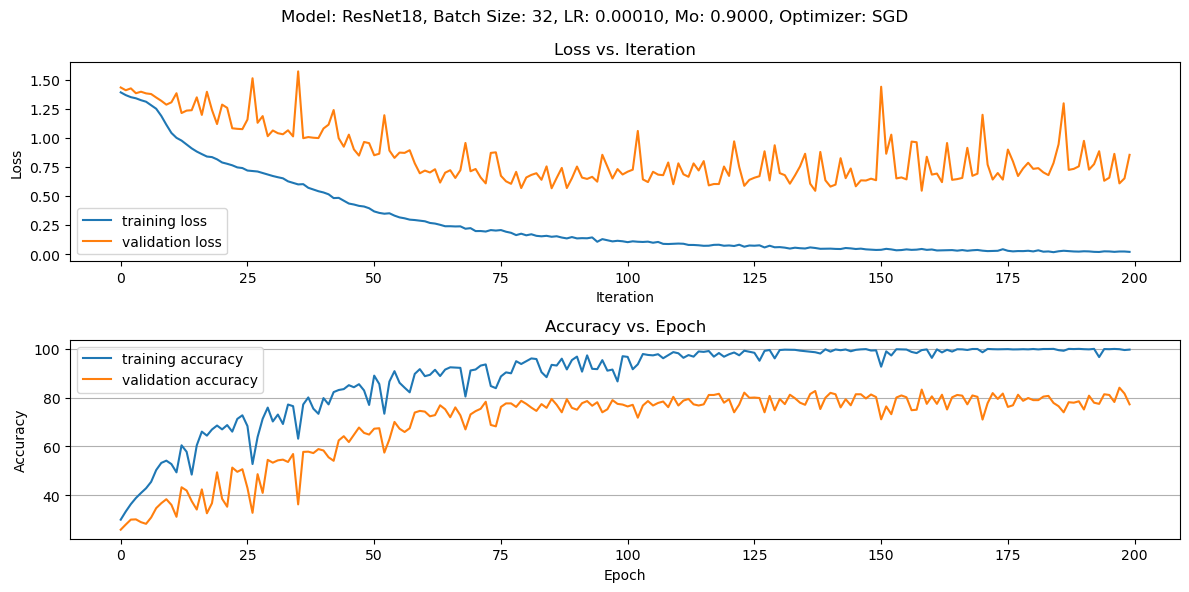

In [15]:
# Plot Learning Curves
ML.plot_learning_curve(hist)

In [16]:
print('last validation data accuracy', hist['validation_accuracy'][-1])

last validation data accuracy 77.23342939481267


In [17]:
print('highest validation accuracy achieved: ' , max(hist['validation_accuracy']))

highest validation accuracy achieved:  84.0537944284342


In [18]:
hist['validation_accuracy'].index(max(hist['validation_accuracy']))

197

In [19]:
predictions, test_labels = ML.predict(model=model, test_loader=test_loader, device=device)

  0%|          | 0/63 [00:00<?, ?batch/s]

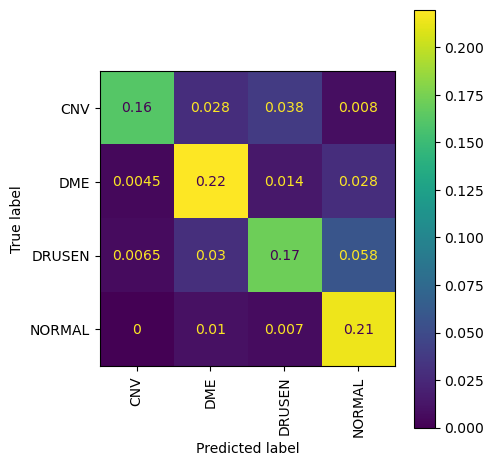

In [20]:
cm = confusion_matrix(test_labels, predictions, normalize='all')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(include_values=True, xticks_rotation='vertical', ax=ax)
plt.tight_layout()
plt.show()

In [21]:
print('test data accuracy: ', ML.test_accuracy(model=model, data_loader=test_loader, device=device))

  0%|          | 0/63 [00:00<?, ?batch/s]

test data accuracy:  76.76616915422886


In [ ]:
##### LAST STEP, SAVE MODEL
path_model_save = #choose path to save model
torch.save(net.state_dict(), path_model_save)

**Fifth Step:** Model interpretability.

For this assignment, you will interpret the model's results through the use of saliency mapping. You will use the following package: [GitHub](https://github.com/jacobgil/pytorch-grad-cam).

You are expected to install the package on your environment and go through the GitHub to learn its application. Below is an example code to help you get started:

In [ ]:
### Sample Use with ResNet50:

from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50

model = resnet50(pretrained=True)
target_layers = [model.layer4[-1]]


input_tensor = # Your input data


# Note: input_tensor can be a batch tensor with several images!

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=False)

targets = ### your label

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)